In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from utils import columns, clean_df, numerics, summary
from pycaret.regression import *

%config Completer.use_jedi = False
seed = 1

# Agenda
1. Problem
2. EDA
3. Solution
    - Base Model (multivariate linear regression)
    - Advanced Framework
    - Production Scenario
4. Conclusion

# 1. Problem
- Simple regression model
- Target: **normalized losses** ~ "*relative average loss payment per insured vehicle year.*" ([UCI](https://archive.ics.uci.edu/ml/datasets/Automobile))
- Evaluate with MSE

# 2. EDA

This looks nice: https://medium.com/analytics-vidhya/implementing-linear-regression-using-sklearn-76264a3c073c

In [2]:
df = pd.read_csv("data/imports-85.data", header=None, names=columns)
df = clean_df(df)
df.head(3)

164 rows (80.0%) left after preprocessing


,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.4,10.0,102.0,5500.0,24,30,13950.0
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.4,8.0,115.0,5500.0,18,22,17450.0
6,158.0,audi,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.4,8.5,110.0,5500.0,19,25,17710.0


In [3]:
# histogram target + log(target)
#pd.Series(np.log(y)).plot.hist()
#y.plot.hist()





# fancy stuff to display relations





# 3. Solution

In [4]:
data = df.sample(frac=0.9, random_state=seed)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (148, 25)
Unseen Data For Predictions: (16, 25)


## 3.1 Base Model
In a simple approach we'll consider continuous variables only.

In [5]:
# TODO: Check for linearity etc (use scripts from previous notebook)

cols = list(data.columns)
target, num_features = cols[0], [c for c in cols[1:] if c in numerics]

In [6]:
X,y = data[num_features], data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

In [7]:
model = LinearRegression().fit(X_train, y_train)
summary(model, X_train, y_train)

Call:
lm(formula = normalized-losses ~ wheel-base + length + width + height + curb-weight + engine-size + bore + stroke + compression-ratio + horsepower + peak-rpm + city-mpg + highway-mpg + price) 

                       Coefficients  Std. Error  t value  Pr(>|t|)
0         (Intercept)      573.8657     214.309    2.678     0.008
1          wheel-base        0.5757       1.331    0.433     0.666
2              length        0.2323       0.677    0.343     0.732
3               width       -1.4625       3.441   -0.425     0.672
4              height       -7.5976       1.692   -4.491     0.000
5         curb-weight        0.0192       0.022    0.858     0.392
6         engine-size        0.0765       0.244    0.313     0.755
7                bore      -30.2625      14.769   -2.049     0.042
8              stroke      -10.7359      10.732   -1.000     0.319
9   compression-ratio        0.1486       1.073    0.138     0.890
10         horsepower       -0.0592       0.254   -0.233     0.

In [8]:
MSE = mean_squared_error(y_test, model.predict(X_test))
RMSE = mean_squared_error(y_test, model.predict(X_test), squared=False)

print(MSE,RMSE)

605.0384502376851 24.59752935230864


## 3.2 Modeling fun with PyCaret
Instead of writing ✍️ a parameter optimization and apply stacking by hand, I use pycaret since it saves me a lot of time.

In [16]:
params = {
    "data": data,
    "target": "normalized-losses",
    "train_size": 0.8,
    "categorical_features": [c for c in cols[1:] if c not in numerics],
    "remove_multicollinearity": True,
    "verbose": False,
    "silent": True,
    "fold": 10,
    "session_id": seed,
#    "feature_selection": True,
#    "feature_selection_threshold": 0.1,
}

regr = setup(**params)

In [29]:
# Find best models
top3 = compare_models(n_select = 3,sort = 'MSE',
                      exclude=['huber','lar','par', 'knn', 'llar', 'br', 'en','lr'],
                      #verbose=False
                     )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,12.1613,412.8174,18.4699,0.4858,0.1406,0.0997,0.0120
catboost,CatBoost Regressor,12.8999,434.8386,19.6723,0.3689,0.1501,0.1062,0.2090
et,Extra Trees Regressor,10.9808,464.6888,19.3256,0.3074,0.1454,0.0869,0.0350
xgboost,Extreme Gradient Boosting,14.1075,493.1420,21.3947,0.3373,0.1629,0.1142,0.2150
ridge,Ridge Regression,16.6369,543.7133,22.1717,0.2119,0.1796,0.1388,0.0050
rf,Random Forest Regressor,15.8974,572.1250,22.6354,0.0881,0.1719,0.1310,0.0380
lightgbm,Light Gradient Boosting Machine,18.0427,603.7153,23.6192,0.1082,0.1831,0.1494,0.0820
ada,AdaBoost Regressor,18.8554,613.9751,23.6203,0.0736,0.1863,0.1606,0.0170
lasso,Lasso Regression,19.8008,656.8638,24.6861,0.1263,0.1975,0.1656,0.0060
dt,Decision Tree Regressor,13.9803,817.4803,25.4974,-0.1124,0.1968,0.1113,0.0050


In [30]:
stacker = stack_models(estimator_list = top3[1:], meta_model = top3[0], 
                       #verbose=False
                      )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,20.1684,802.3063,28.3250,0.1405,0.2140,0.1469
1,13.0364,250.4592,15.8259,0.6740,0.1324,0.1182
2,14.8239,445.7056,21.1117,-1.9913,0.2150,0.1834
3,15.0387,590.0438,24.2908,0.6929,0.1693,0.1109
4,10.5658,188.6643,13.7355,0.7586,0.1108,0.0913
5,7.2998,93.6568,9.6776,0.9242,0.0805,0.0614
6,9.5693,250.6061,15.8305,0.8063,0.1036,0.0657
7,8.9305,146.8536,12.1183,0.7453,0.0955,0.0759
8,20.5241,1611.5258,40.1438,0.3014,0.2257,0.1180
9,15.7227,534.9257,23.1285,-0.0155,0.1957,0.1362


In [56]:
tuned_best_model_optuna = tune_model(
    stacker,
    search_library="tune-sklearn",
    search_algorithm="optuna",
    n_iter=3,
    optimize = "MSE"
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,18.9604,722.5936,26.8811,0.2259,0.1970,0.1345
1,13.1811,222.9276,14.9308,0.7098,0.1327,0.1249
2,22.8987,651.4955,25.5244,-3.3725,0.2656,0.2784
3,21.1310,867.2480,29.4491,0.5486,0.1985,0.1529
4,8.7626,111.6669,10.5673,0.8571,0.0955,0.0788
5,11.6072,284.0524,16.8539,0.7701,0.1451,0.1029
6,15.2789,477.9701,21.8625,0.6306,0.1600,0.1218
7,10.5996,155.8724,12.4849,0.7296,0.1199,0.1030
8,21.6557,1562.8714,39.5332,0.3225,0.2252,0.1298
9,13.5193,365.6614,19.1223,0.3059,0.1583,0.1140


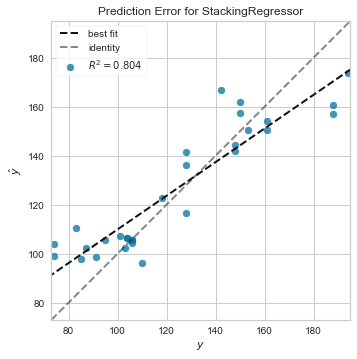

In [57]:
plot_model(tuned_best_model_optuna, 'error')

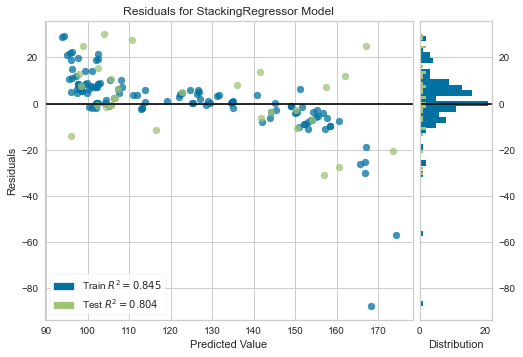

In [58]:
plot_model(tuned_best_model_optuna, 'residuals')

In [59]:
save_model(stacker, "stacked_regressior_01")
loaded_model = load_model("stacked_regressior_01")

Transformation Pipeline and Model Succesfully Saved
Transformation Pipeline and Model Successfully Loaded


<AxesSubplot:ylabel='Frequency'>

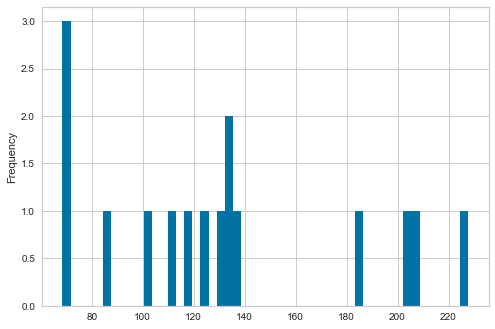

In [60]:
predictions = predict_model(loaded_model, data = data_unseen[list(data_unseen.columns)[1:]])
predictions["Label"].plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

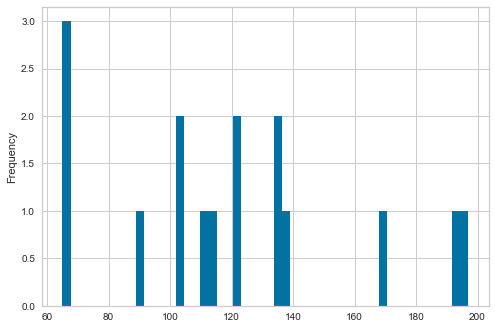

In [61]:
data_unseen["normalized-losses"].plot.hist(bins=50)

In [67]:
best_model = compare_models(sort = 'MSE',
                      exclude=['huber','lar','par', 'knn', 'llar', 'br', 'en','lr'],
                      #verbose=False
                     )

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,12.1613,412.8174,18.4699,0.4858,0.1406,0.0997,0.0110
catboost,CatBoost Regressor,12.8999,434.8386,19.6723,0.3689,0.1501,0.1062,0.2060
et,Extra Trees Regressor,10.9808,464.6888,19.3256,0.3074,0.1454,0.0869,0.0420
xgboost,Extreme Gradient Boosting,14.1075,493.1420,21.3947,0.3373,0.1629,0.1142,0.4210
ridge,Ridge Regression,16.6369,543.7133,22.1717,0.2119,0.1796,0.1388,0.0050
rf,Random Forest Regressor,15.8974,572.1250,22.6354,0.0881,0.1719,0.1310,0.0430
lightgbm,Light Gradient Boosting Machine,18.0427,603.7153,23.6192,0.1082,0.1831,0.1494,0.0740
ada,AdaBoost Regressor,18.8554,613.9751,23.6203,0.0736,0.1863,0.1606,0.0150
lasso,Lasso Regression,19.8008,656.8638,24.6861,0.1263,0.1975,0.1656,0.0070
dt,Decision Tree Regressor,13.9803,817.4803,25.4974,-0.1124,0.1968,0.1113,0.0050


In [74]:
tuned_best_model_single_optuna = tune_model(
    best_model,
    search_library="tune-sklearn",
    search_algorithm="optuna",
    n_iter=10,
    optimize = "MSE"
)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,17.9143,736.2446,27.1338,0.2112,0.2039,0.1265
1,14.2332,351.7685,18.7555,0.5421,0.1614,0.1363
2,17.4540,465.8953,21.5846,-2.1268,0.2309,0.2156
3,15.3345,541.6297,23.2729,0.7181,0.1604,0.1123
4,9.6589,168.7391,12.9900,0.7841,0.1098,0.0834
5,8.3103,125.2333,11.1908,0.8987,0.1074,0.0767
6,10.6953,322.9302,17.9703,0.7505,0.1232,0.0746
7,12.0601,215.4458,14.6781,0.6263,0.1189,0.1051
8,18.1673,1392.8756,37.3212,0.3962,0.2055,0.1067
9,16.0401,397.6961,19.9423,0.2450,0.1636,0.1300


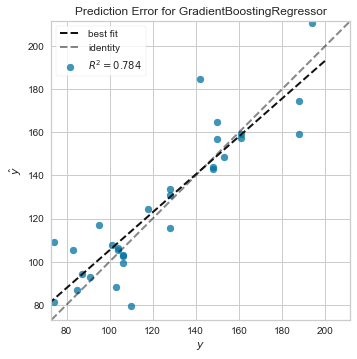

In [75]:
plot_model(tuned_best_model_single_optuna, 'error')

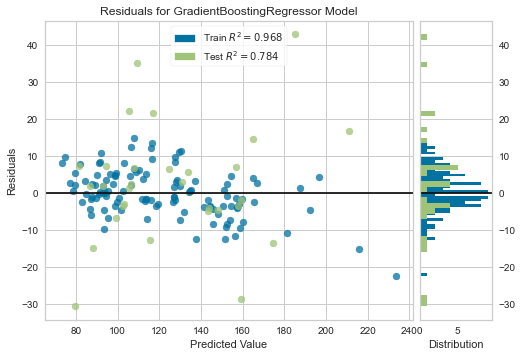

In [76]:
plot_model(tuned_best_model_single_optuna, 'residuals')

In [77]:
tuned_best_model_single_optuna

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01835581291203123,
                          loss='ls', max_depth=5,
                          max_features=0.9451573018558573, max_leaf_nodes=None,
                          min_impurity_decrease=3.5821244461862384e-07,
                          min_impurity_split=None, min_samples_leaf=1,
                          min_samples_split=9, min_weight_fraction_leaf=0.0,
                          n_estimators=297, n_iter_no_change=None,
                          presort='deprecated', random_state=1,
                          subsample=0.4243551936515242, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
#help(setup)
#help(compare_models)
#help(plot_model)
#help(predict_model)

Help on function setup in module pycaret.regression:

setup(data: pandas.core.frame.DataFrame, target: str, train_size: float = 0.7, test_data: Union[pandas.core.frame.DataFrame, NoneType] = None, preprocess: bool = True, imputation_type: str = 'simple', iterative_imputation_iters: int = 5, categorical_features: Union[List[str], NoneType] = None, categorical_imputation: str = 'constant', categorical_iterative_imputer: Union[str, Any] = 'lightgbm', ordinal_features: Union[Dict[str, list], NoneType] = None, high_cardinality_features: Union[List[str], NoneType] = None, high_cardinality_method: str = 'frequency', numeric_features: Union[List[str], NoneType] = None, numeric_imputation: str = 'mean', numeric_iterative_imputer: Union[str, Any] = 'lightgbm', date_features: Union[List[str], NoneType] = None, ignore_features: Union[List[str], NoneType] = None, normalize: bool = False, normalize_method: str = 'zscore', transformation: bool = False, transformation_method: str = 'yeo-johnson', hand

## 3.3 Production Scenario

# Conclusion

### Sources
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
- https://boostedml.com/2019/06/linear-regression-in-r-interpreting-summarylm.html
- https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
- 